# Обучение модели Car Damage Detection

Этот ноутбук содержит шаги по подготовке данных, обучению и валидации модели YOLO11 для детекции повреждений автомобилей.

## 1. Установка зависимостей

Устанавливаем библиотеку `ultralytics` для работы с моделью YOLO.

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00


## 2. Импорт библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pycocotools.coco import COCO
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco

from google.colab import drive
drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


## 3. Просмотр датасета CarDD_COCO

Загружаем аннотации для тренировочного набора данных.

In [10]:
annotation = 'drive/MyDrive/Colab Notebooks/CAR_DAMAGE/CarDD_COCO/annotations/instances_train2017.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=2.64s)
creating index...
index created!


Просматриваем какие классы есть в датасете.

In [11]:
cats = coco.loadCats(coco.getCatIds())
for cat in cats:
    print(f"ID {cat['id']}: {cat['name']}")

ID 1: dent
ID 2: scratch
ID 3: crack
ID 4: glass shatter
ID 5: lamp broken
ID 6: tire flat


Визуализируем аннотации.

In [ ]:
# Функция для отрисовки bounding_box'ов и сегментации
def draw_bbox_seg(img, anns, coco):
    overlay = img.copy()

    categories = coco.loadCats(coco.getCatIds())
    cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
    color_map = {
        'dent': (255, 0, 0),
        'scratch': (0, 255, 0),
        'crack': (0, 0, 255),
        'glass shatter': (255, 255, 0),
        'lamp broken': (0, 255, 255),
        'tire flat': (255, 0, 255)
    }

    mask = np.zeros_like(img)

    for ann in anns:
        cat_id = ann['category_id']
        cat_name = cat_id_to_name.get(cat_id, 'name')
        color = color_map.get(cat_name, (255, 255, 255))

        x, y, w, h = ann['bbox']
        cv2.rectangle(overlay, (int(x), int(y)), (int(x+w), int(y+h)), color, 2)
        cv2.putText(overlay, cat_name, (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        for seg in ann['segmentation']:
            poly = np.array([(seg[i], seg[i+1]) for i in range(0, len(seg), 2)], np.int32)

            cv2.polylines(overlay, [poly], True, color, 2)

            cv2.fillPoly(mask, [poly], color)
    cv2.addWeighted(mask, 0.4, overlay, 0.6, 0, overlay)

    return overlay

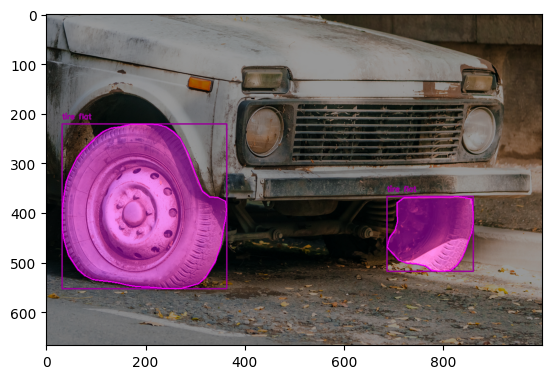

In [ ]:
img_ids = coco.getImgIds()
img_info = coco.loadImgs(img_ids[0])[0]

ann_ids = coco.getAnnIds(imgIds=img_info['id'])
anns = coco.loadAnns(ann_ids)

img = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/images/test2017/{img_info["file_name"]}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(draw_bbox_seg(img, anns, coco))
plt.show()

В датасете есть аннотации как для задачи детекции, так и для задачи сегментации.

Будем работать только с задачей детекции повреждений.

##4. Подготовка данных

Конвертируем аннотации для модели YOLO.

In [ ]:
# Пути к аннотациям
ann_dir = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/CarDD_COCO/annotations/'
output_dir = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset'

convert_coco(
    ann_dir,
    output_dir,
    use_segments=False,
    use_keypoints=False
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Annotations /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/CarDD_COCO/annotations/instances_test2017.json: 100%|██████████| 374/374 [00:02<00:00, 132.60it/s]
Annotations /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/CarDD_COCO/annotations/instances_train2017.json: 100%|██████████| 2816/2816 [00:23<00:00, 122.40it/s]
Annotations /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/CarDD_COCO/annotations/instances_val2017.json: 100%|██████████| 810/810 [00:06<00:00, 117.12it/s]

COCO data converted successfully.
Results saved to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset


Теперь аннотации стали формата: (4 координаты + 6 классов)

## 5. Обучение модели yolo11m

### Обучение модели без настройки гиперпараметров

In [ ]:
conf = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml'

model = YOLO('yolo11m.pt')

results = model.train(data=conf, epochs=20, imgsz=640, batch=8)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 155MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    542720  ultralytics.nn.modules.block.C3k2            [1024, 256, 1, True]          
 17                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 20                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 102MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 12.1±25.8 ms, read: 1.3±0.4 MB/s, size: 771.1 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [24:29<00:00,  1.92it/s]


train: New cache created: /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 1.4±0.4 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [07:04<00:00,  1.91it/s]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.15G      1.588      2.628      1.759         55        640: 100%|██████████| 352/352 [04:35<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:30<00:00,  1.68it/s]


                   all        810       1744      0.363      0.258       0.22      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.74G       1.77      2.602      1.906         43        640: 100%|██████████| 352/352 [02:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:20<00:00,  2.54it/s]


                   all        810       1744      0.458      0.292      0.261      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       5.8G      1.741      2.544       1.89         31        640: 100%|██████████| 352/352 [02:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


                   all        810       1744      0.599      0.341       0.31      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.87G        1.7      2.512      1.852         30        640: 100%|██████████| 352/352 [02:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:18<00:00,  2.71it/s]


                   all        810       1744      0.648      0.341       0.38      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.93G      1.621      2.334      1.792         31        640: 100%|██████████| 352/352 [01:59<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.89it/s]


                   all        810       1744      0.672      0.464      0.472      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         6G       1.54      2.202      1.741         31        640: 100%|██████████| 352/352 [01:59<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.97it/s]


                   all        810       1744       0.46      0.466      0.482      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.06G      1.482      2.103      1.691         38        640: 100%|██████████| 352/352 [01:59<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.97it/s]


                   all        810       1744      0.628      0.467      0.479      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.13G      1.443      2.011      1.642         37        640: 100%|██████████| 352/352 [01:57<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:18<00:00,  2.74it/s]


                   all        810       1744      0.596      0.484      0.526      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       6.2G      1.389      1.925      1.607         38        640: 100%|██████████| 352/352 [01:57<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


                   all        810       1744      0.609      0.528      0.526      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.27G      1.344      1.835       1.58         36        640: 100%|██████████| 352/352 [01:58<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:16<00:00,  3.05it/s]


                   all        810       1744      0.545      0.558       0.56      0.424
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.33G      1.417      1.905      1.653         13        640: 100%|██████████| 352/352 [01:57<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:18<00:00,  2.79it/s]

                   all        810       1744      0.571      0.563      0.566      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       6.4G      1.374      1.807      1.616         25        640: 100%|██████████| 352/352 [02:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.85it/s]


                   all        810       1744      0.556      0.519      0.559      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.46G      1.336       1.72      1.588         15        640: 100%|██████████| 352/352 [01:56<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:16<00:00,  3.05it/s]


                   all        810       1744      0.595      0.564      0.578      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.53G      1.292      1.644      1.544         10        640: 100%|██████████| 352/352 [01:57<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.98it/s]


                   all        810       1744      0.601      0.582      0.609      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       6.6G      1.257      1.572      1.521         17        640: 100%|██████████| 352/352 [01:58<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:18<00:00,  2.82it/s]


                   all        810       1744      0.655      0.576      0.622       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.66G      1.206      1.501      1.486         25        640: 100%|██████████| 352/352 [01:56<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  3.00it/s]


                   all        810       1744      0.613      0.618      0.622      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.73G      1.175      1.436      1.447         14        640: 100%|██████████| 352/352 [01:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.99it/s]


                   all        810       1744       0.63      0.633      0.648      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       6.8G      1.141       1.36      1.418         17        640: 100%|██████████| 352/352 [01:59<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]

                   all        810       1744      0.632      0.656      0.663      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.86G      1.112      1.318      1.405         16        640: 100%|██████████| 352/352 [02:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:17<00:00,  2.98it/s]


                   all        810       1744      0.684      0.661      0.686      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.93G      1.081       1.25      1.371         19        640: 100%|██████████| 352/352 [01:57<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:16<00:00,  3.00it/s]


                   all        810       1744      0.703      0.654       0.68      0.545

20 epochs completed in 0.819 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:19<00:00,  2.67it/s]


                   all        810       1744      0.704      0.653       0.68      0.545
                  dent        352        501      0.642      0.473       0.52      0.281
               scratch        431        728      0.597      0.497      0.526      0.297
                 crack        122        177      0.384      0.282      0.248      0.123
         glass_shatter        134        135      0.955      0.963      0.984      0.932
           lamp_broken        139        141      0.728      0.809      0.849      0.742
             tire_flat         59         62      0.917      0.896      0.956      0.895
Speed: 0.2ms preprocess, 7.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train



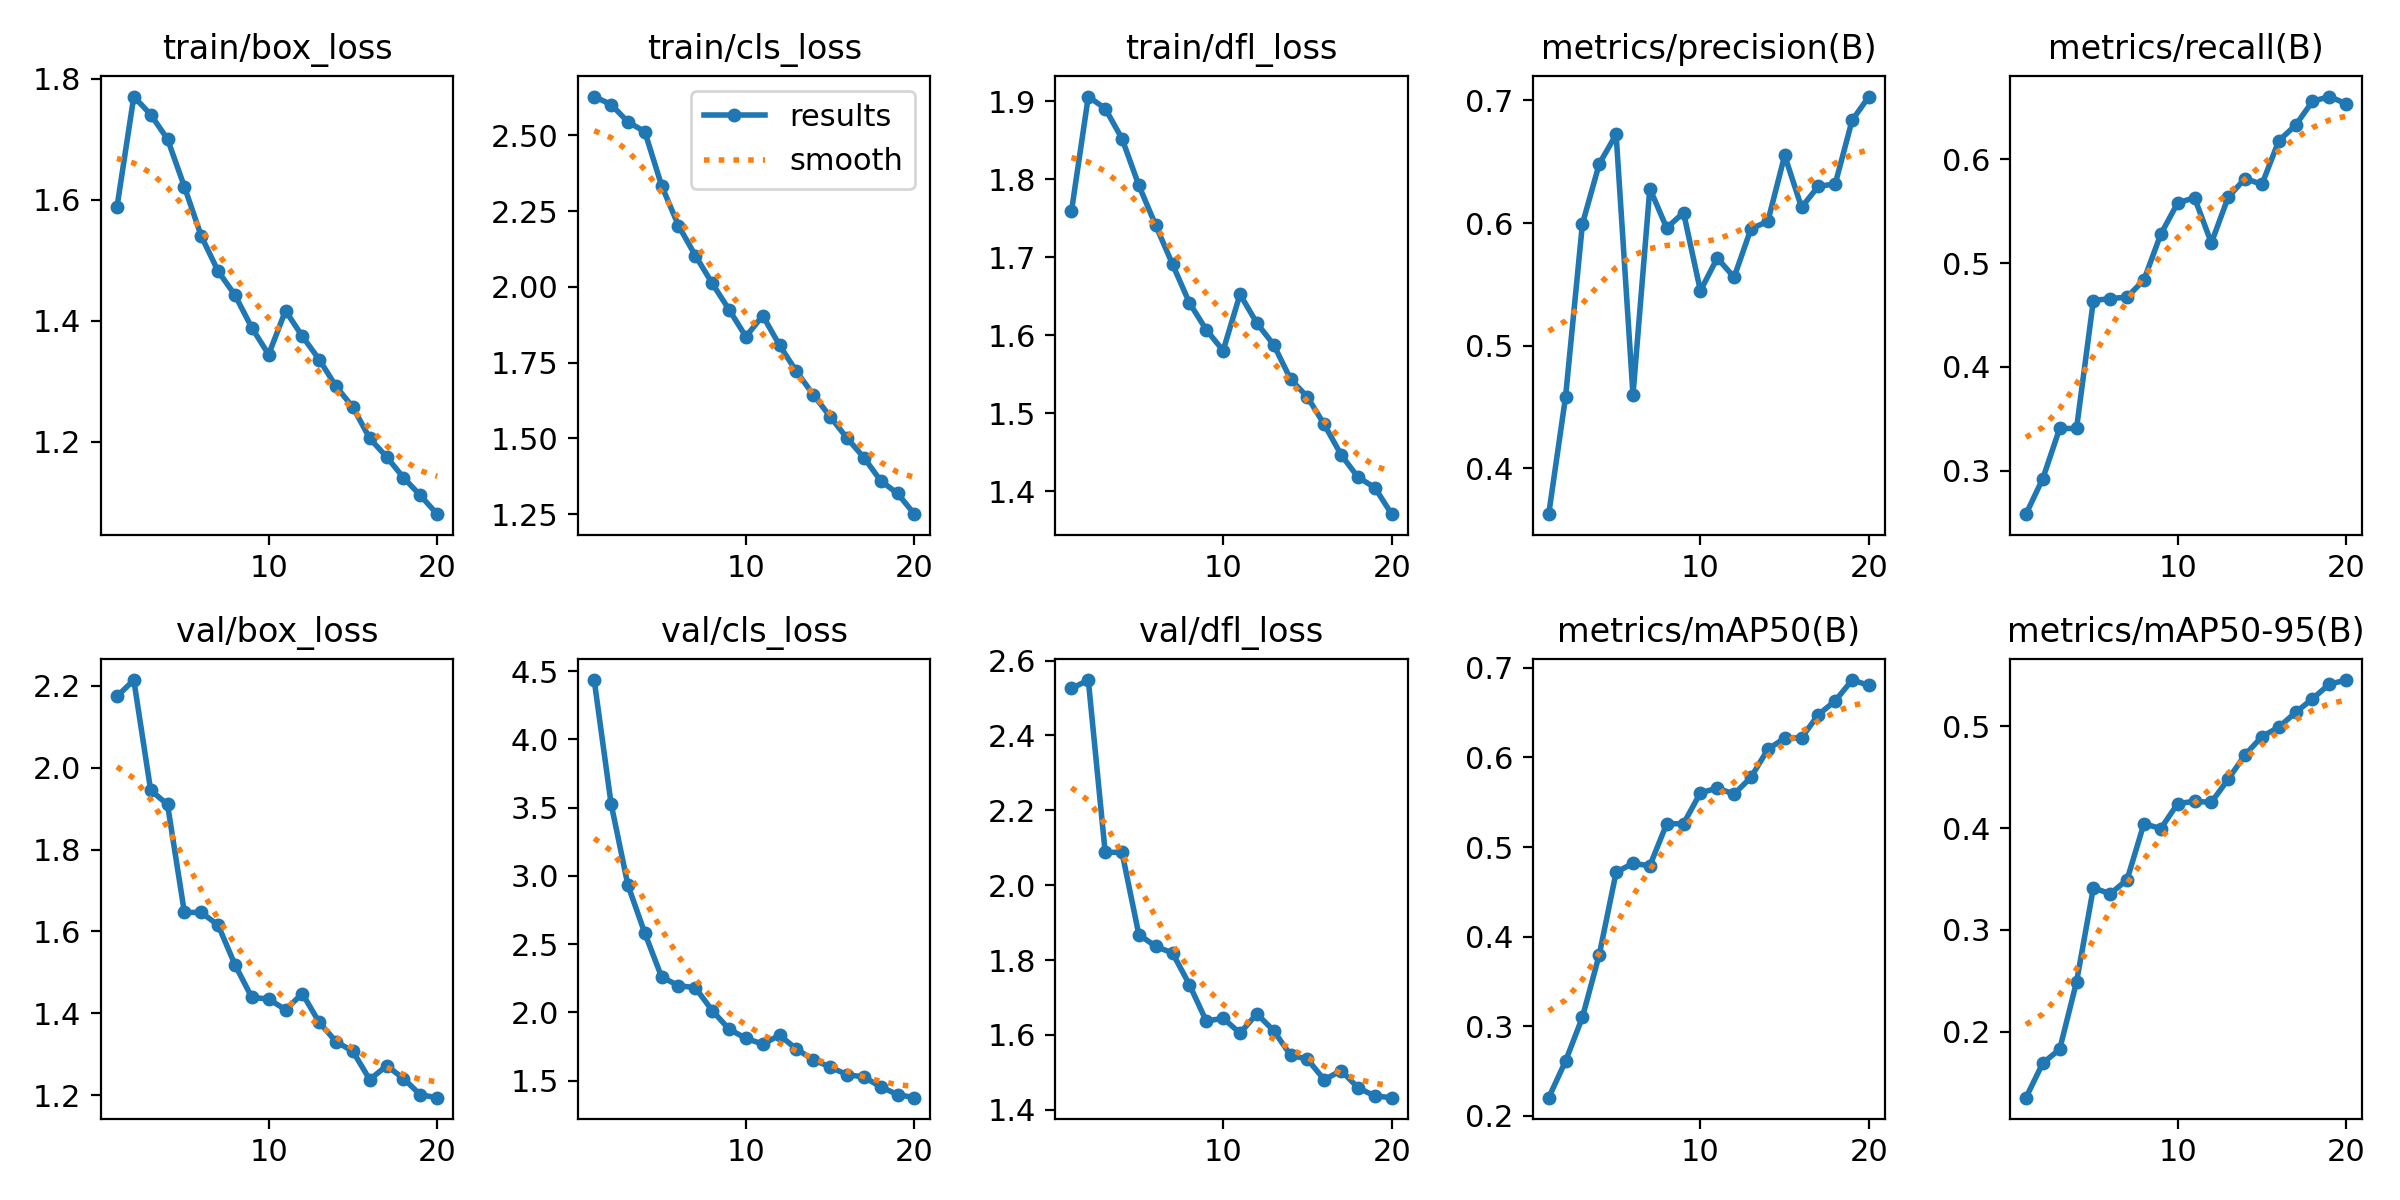

Потери уменьшаются с 1-ой по 20-ю эпохи, что указывает на успешную сходимость модели.

Рост метрик mAP замедлился к 20-й эпохе, но продолжает увеличиваться, что указывает на потенциал дальнейшего улучшения. Попробуем увеличить количество эпох.


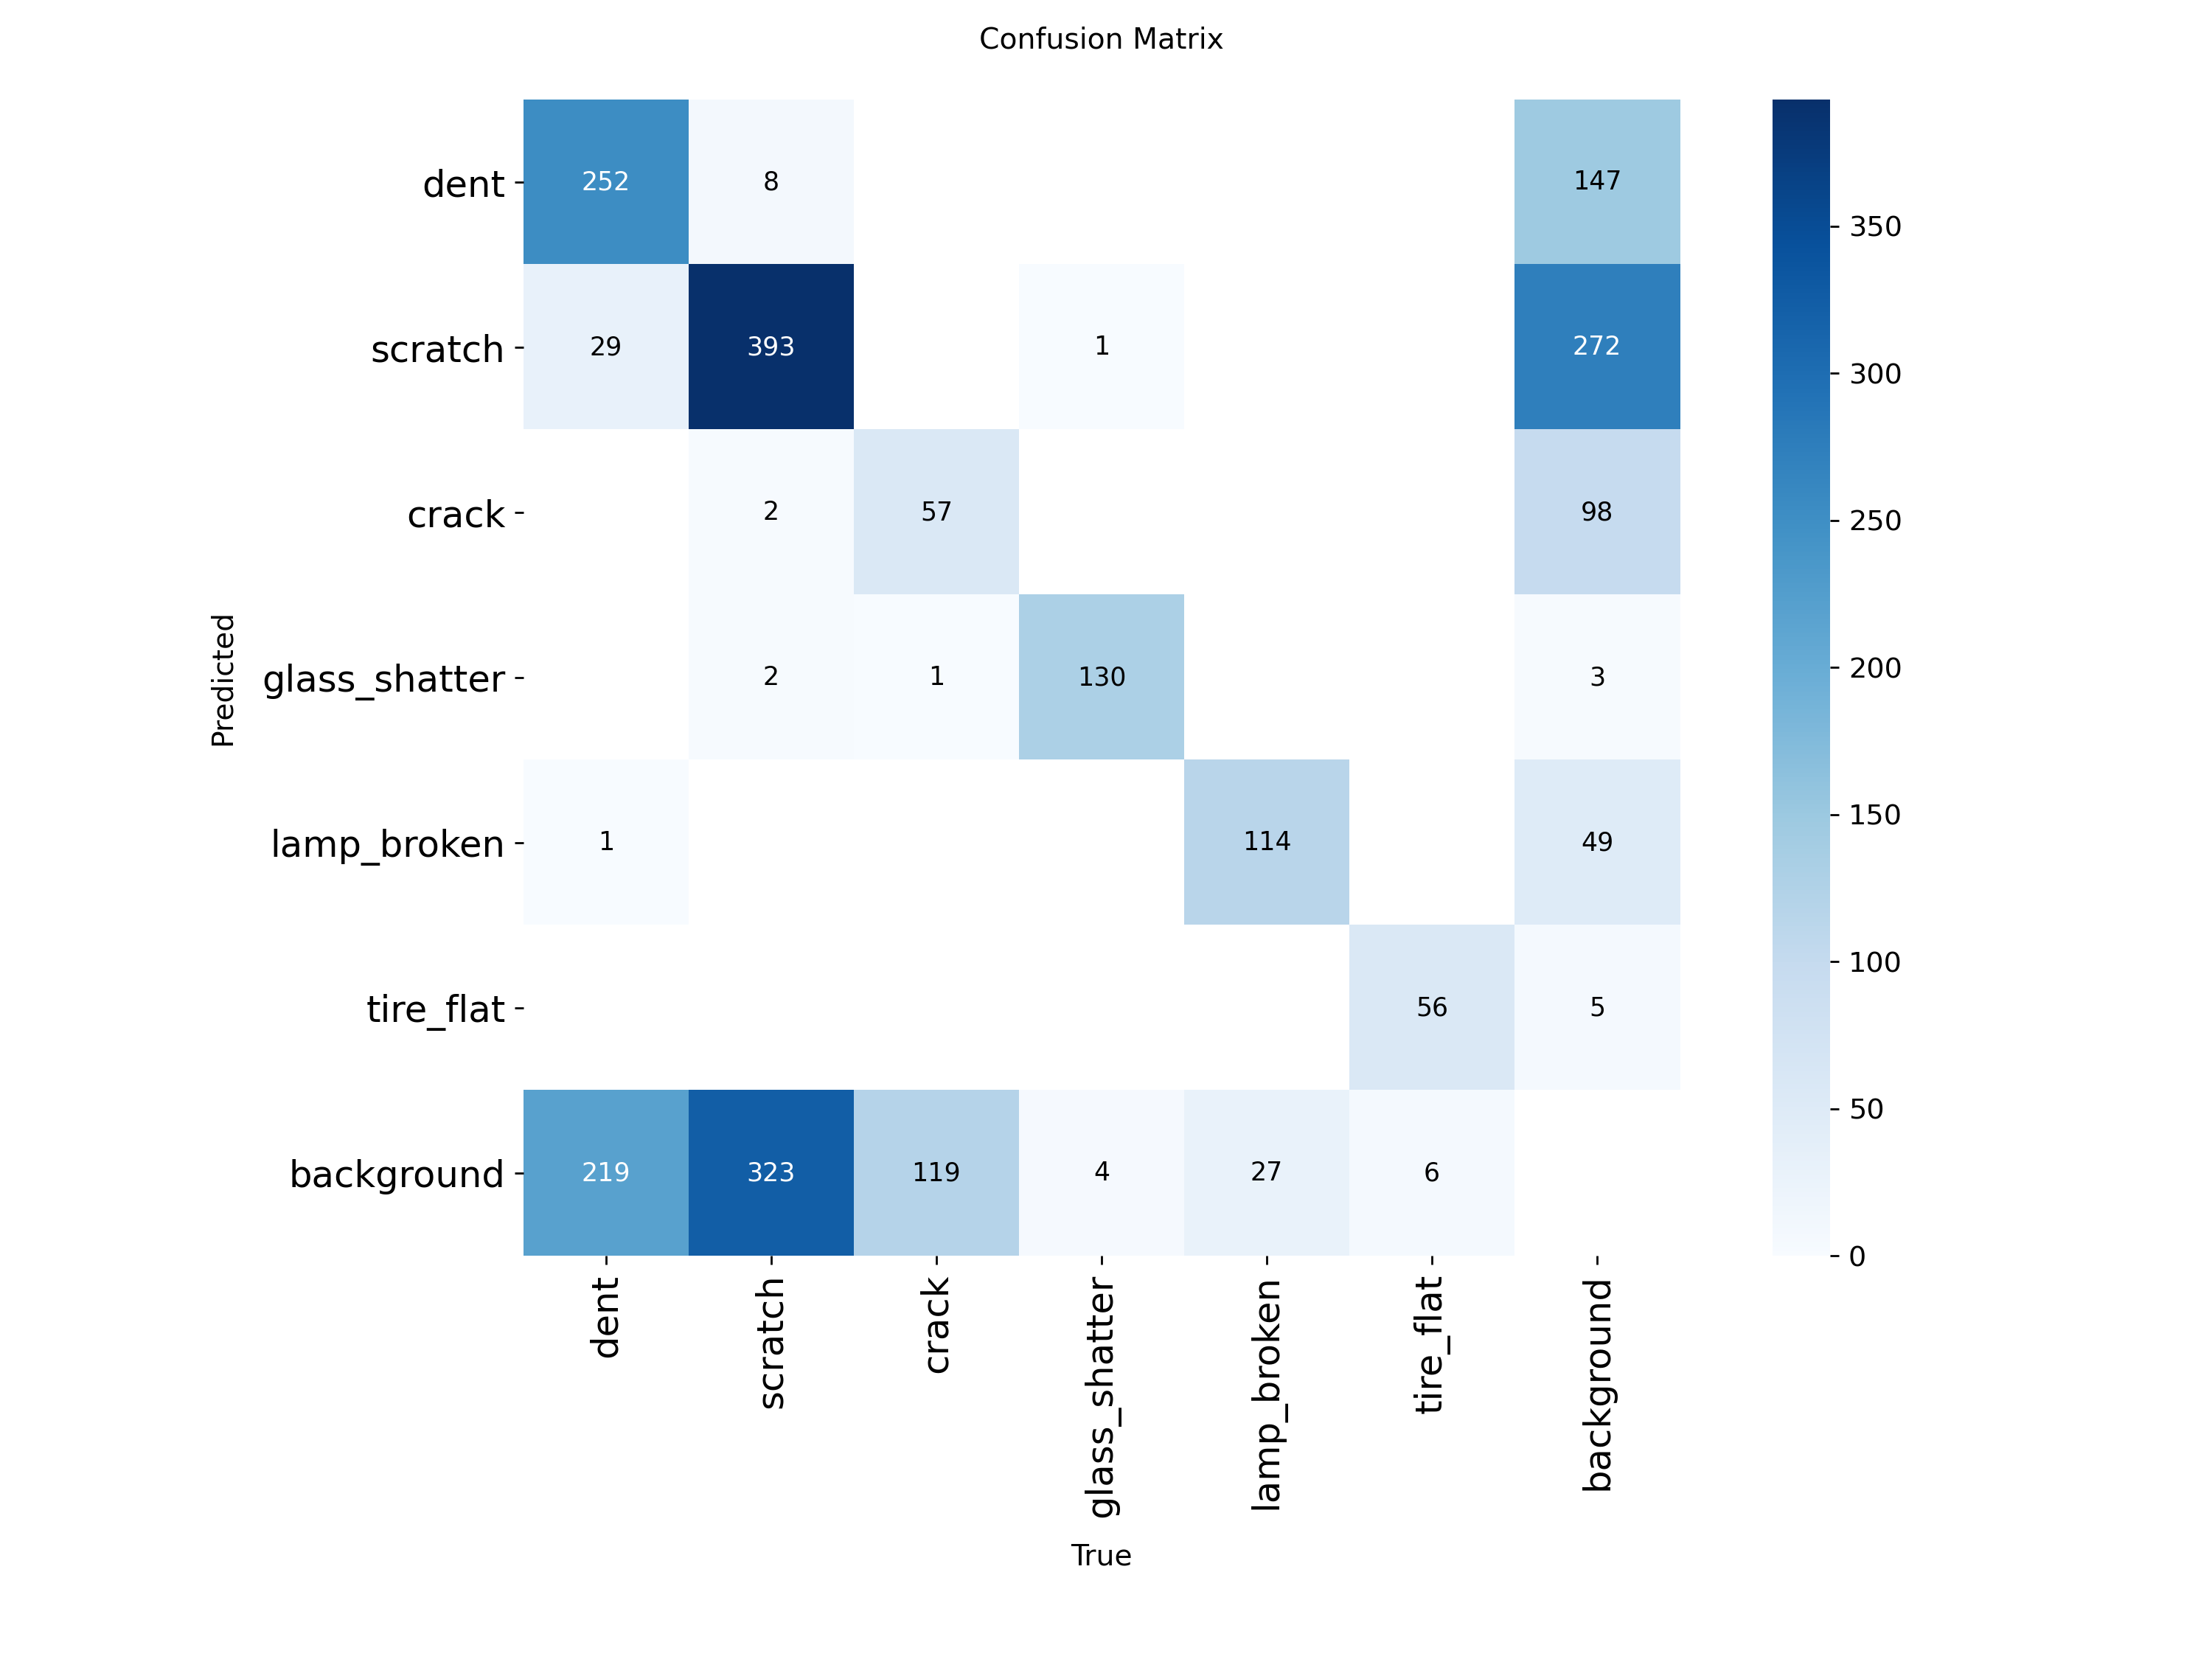

Матрица ошибок показывает, что glass_shatter, tire_flat и lamp_broken имеют высокую точность детекции (скорее всего из-за чётких визуальных признаков), но остальные классы иногда путаются друг с другом и часто определяются как фон.

Добавим аугментации и заморозим несколько первых слоёв, чтобы сосредоточить обучение на выходных слоях и улучшить обобщающую способность. Это должно повысить mAP, особенно для слабых классов.

Проверим как работает модель на изображении.


image 1/1 /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/images/test2017/000012.jpg: 448x640 1 tire_flat, 28.6ms
Speed: 2.3ms preprocess, 28.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict6


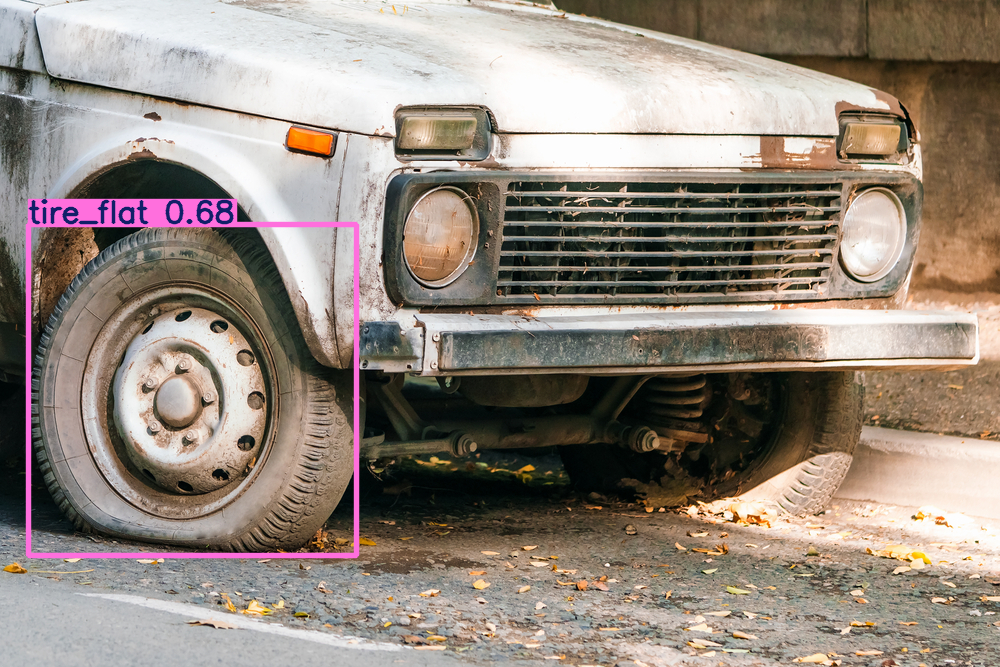

In [ ]:
best_model = YOLO('runs/detect/train/weights/best.pt')
val_img = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/images/test2017/000012.jpg'

results = best_model.predict(source=val_img)
results[0].show()

### Обучение с настройкой гиперпараметров для аугментации изображений

In [ ]:
updated_model = YOLO('yolo11m.pt')

conf = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml'

updated_model.train(data=conf,
            epochs=50, # Увеличиваем количество эпох с 20 до 50.
            imgsz=640,
            batch=16, # Обрабатываем больше изображений за проход.
            optimizer='AdamW',
            lr0=0.0001, # Уменьшаем начальный lr с 0.01 до 0.0001 для более плавной сходимости.
            freeze=10, # Замораживаем первые 10 слоёв для сохранения предобученных весов и ускорения обучения head.
            hsv_h=0.2, # Увеличение вариации оттенков для улучшения устойчивости к изменениям освещения.
            degrees=10.0, # Добавление поворота изображений для учёта разных углов съёмки.
            patience=10, # Автоматическая установка, если метрики не улучшаются.
            project='/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results'
            )

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.2, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspe

train: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.0±2.7 ms, read: 77.2±55.8 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.89G      1.589      2.433      1.776         96        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.742      0.466      0.502      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.89G      1.448      1.904      1.634         76        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.545      0.568      0.564      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.89G      1.409      1.774       1.59         65        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744      0.527      0.588      0.556      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.89G      1.356      1.666      1.562         55        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744       0.59      0.593      0.611      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.89G      1.346      1.594      1.543         81        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.546      0.636      0.601      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.89G      1.305      1.525      1.517         72        640: 100%|██████████| 176/176 [01:43<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.563      0.623      0.602      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.89G      1.292      1.456      1.503         95        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]


                   all        810       1744      0.606      0.624       0.63       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.89G      1.284      1.438      1.491         82        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.622      0.634      0.643      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.89G      1.244      1.391      1.467         74        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.649      0.653      0.661      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.89G      1.245      1.358      1.457         73        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]

                   all        810       1744      0.654      0.661      0.668      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.89G      1.225      1.316      1.437         70        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]

                   all        810       1744      0.625      0.666      0.665      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.89G       1.21      1.286      1.423         79        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.668      0.641      0.664      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.89G      1.203      1.265      1.423         61        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.631      0.669      0.662      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.89G      1.186      1.228      1.412         93        640: 100%|██████████| 176/176 [01:40<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.679      0.671      0.684       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.89G      1.172      1.206      1.406         58        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


                   all        810       1744       0.65      0.683      0.686      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.89G      1.157      1.167       1.39         79        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]

                   all        810       1744      0.722      0.648       0.69      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.89G      1.164      1.158      1.377         82        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744      0.703      0.659      0.697      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.89G      1.131      1.132      1.357         80        640: 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.55it/s]


                   all        810       1744      0.709      0.667       0.69       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.89G      1.126      1.103      1.357         68        640: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.56it/s]

                   all        810       1744      0.677      0.685      0.696      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.89G      1.114      1.073      1.346         73        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.55it/s]


                   all        810       1744      0.725      0.673      0.703      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.89G      1.102      1.056      1.338         87        640: 100%|██████████| 176/176 [01:40<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.53it/s]


                   all        810       1744      0.729      0.666      0.706      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.89G      1.106      1.033       1.33         79        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.56it/s]


                   all        810       1744      0.702      0.667      0.696      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.89G      1.089      1.033       1.32         67        640: 100%|██████████| 176/176 [01:39<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]

                   all        810       1744      0.689      0.694      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.89G       1.08      1.003      1.319         81        640: 100%|██████████| 176/176 [01:38<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.54it/s]


                   all        810       1744      0.726       0.68      0.706      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.89G      1.075      1.004       1.32         76        640: 100%|██████████| 176/176 [01:40<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.50it/s]


                   all        810       1744       0.71      0.685       0.71      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.89G       1.06     0.9598      1.301         55        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.53it/s]

                   all        810       1744      0.715      0.669      0.704      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.89G      1.046     0.9547      1.289         86        640: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.57it/s]


                   all        810       1744      0.709      0.695       0.71      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.89G      1.038     0.9399      1.285         59        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]

                   all        810       1744      0.726      0.668      0.706      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.89G       1.04     0.9248      1.281         68        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.55it/s]


                   all        810       1744      0.708      0.698      0.712      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.89G      1.026     0.9094      1.269         73        640: 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.57it/s]


                   all        810       1744      0.727      0.685      0.713      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.89G      1.025      0.907      1.271         52        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

                   all        810       1744      0.744      0.679      0.715      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.89G      1.017      0.897      1.265         91        640: 100%|██████████| 176/176 [01:37<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.55it/s]

                   all        810       1744      0.709      0.691      0.706      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.89G      1.004     0.8624      1.254         66        640: 100%|██████████| 176/176 [01:37<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.54it/s]


                   all        810       1744      0.694      0.704      0.712      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.89G     0.9983     0.8737      1.257         73        640: 100%|██████████| 176/176 [01:36<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.55it/s]

                   all        810       1744      0.705      0.696      0.715      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.89G     0.9956     0.8596      1.254         74        640: 100%|██████████| 176/176 [01:36<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.741      0.673      0.716      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.89G     0.9855     0.8264      1.245         64        640: 100%|██████████| 176/176 [01:38<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.58it/s]

                   all        810       1744      0.739      0.691      0.718      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.89G     0.9705     0.8113      1.234         60        640: 100%|██████████| 176/176 [01:36<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16<00:00,  1.56it/s]


                   all        810       1744      0.746      0.683      0.716      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.89G     0.9826     0.8181      1.237         89        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]

                   all        810       1744      0.739       0.68      0.722      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.89G     0.9757     0.8079      1.234         76        640: 100%|██████████| 176/176 [01:45<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744      0.757      0.671      0.716      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.89G     0.9642     0.7958      1.229         76        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]

                   all        810       1744       0.74      0.674      0.711       0.56


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.89G     0.8954     0.6349      1.177         39        640: 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]

                   all        810       1744      0.763      0.676      0.713      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.89G     0.8654     0.5942      1.154         28        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.49it/s]

                   all        810       1744      0.721        0.7      0.721      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.89G     0.8608     0.5829      1.153         34        640: 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


                   all        810       1744      0.758      0.684      0.724      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.89G     0.8606     0.5783      1.145         46        640: 100%|██████████| 176/176 [01:41<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


                   all        810       1744      0.755      0.682      0.726      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.89G     0.8492     0.5657      1.139         39        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.742      0.694      0.724      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.89G      0.841     0.5516      1.132         35        640: 100%|██████████| 176/176 [01:42<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.746      0.685       0.72      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.89G     0.8374     0.5456      1.134         34        640: 100%|██████████| 176/176 [01:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744       0.74      0.696      0.724      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.89G      0.835      0.543      1.133         45        640: 100%|██████████| 176/176 [01:45<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]

                   all        810       1744      0.746      0.687      0.728      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.89G     0.8141     0.5275      1.118         25        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


                   all        810       1744      0.735      0.699      0.727      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.89G     0.8237     0.5239      1.117         42        640: 100%|██████████| 176/176 [01:44<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.736      0.697      0.727      0.573

50 epochs completed in 1.677 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2/weights/last.pt, 40.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2/weights/best.pt, 40.5MB

Validating /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


                   all        810       1744      0.752      0.684      0.726      0.576
                  dent        352        501      0.619      0.471      0.513      0.295
               scratch        431        728      0.613      0.517      0.534      0.305
                 crack        122        177      0.609      0.406      0.454      0.241
         glass_shatter        134        135      0.966      0.978      0.993      0.949
           lamp_broken        139        141      0.827      0.816      0.894      0.761
             tire_flat         59         62      0.876      0.919      0.971      0.906
Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be04d40b010>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Проверим как работает модель на изображении.


image 1/1 /content/1701088890162542985.jpg: 448x640 1 scratch, 46.9ms
Speed: 3.0ms preprocess, 46.9ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


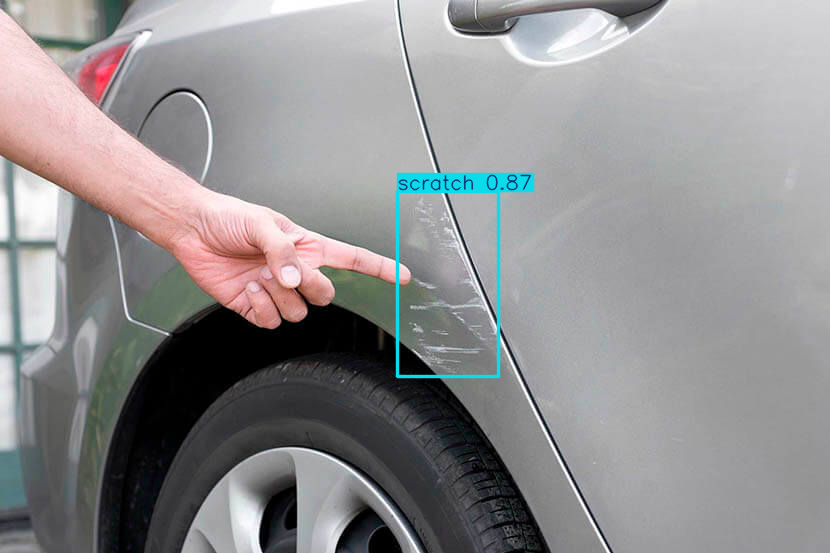

In [ ]:
updated_best_model = YOLO('/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/results/train2/weights/best.pt')
img_path = '/content/1701088890162542985.jpg'

predicted_bbox = updated_best_model.predict(img_path, conf=0.4)
predicted_bbox[0].show()

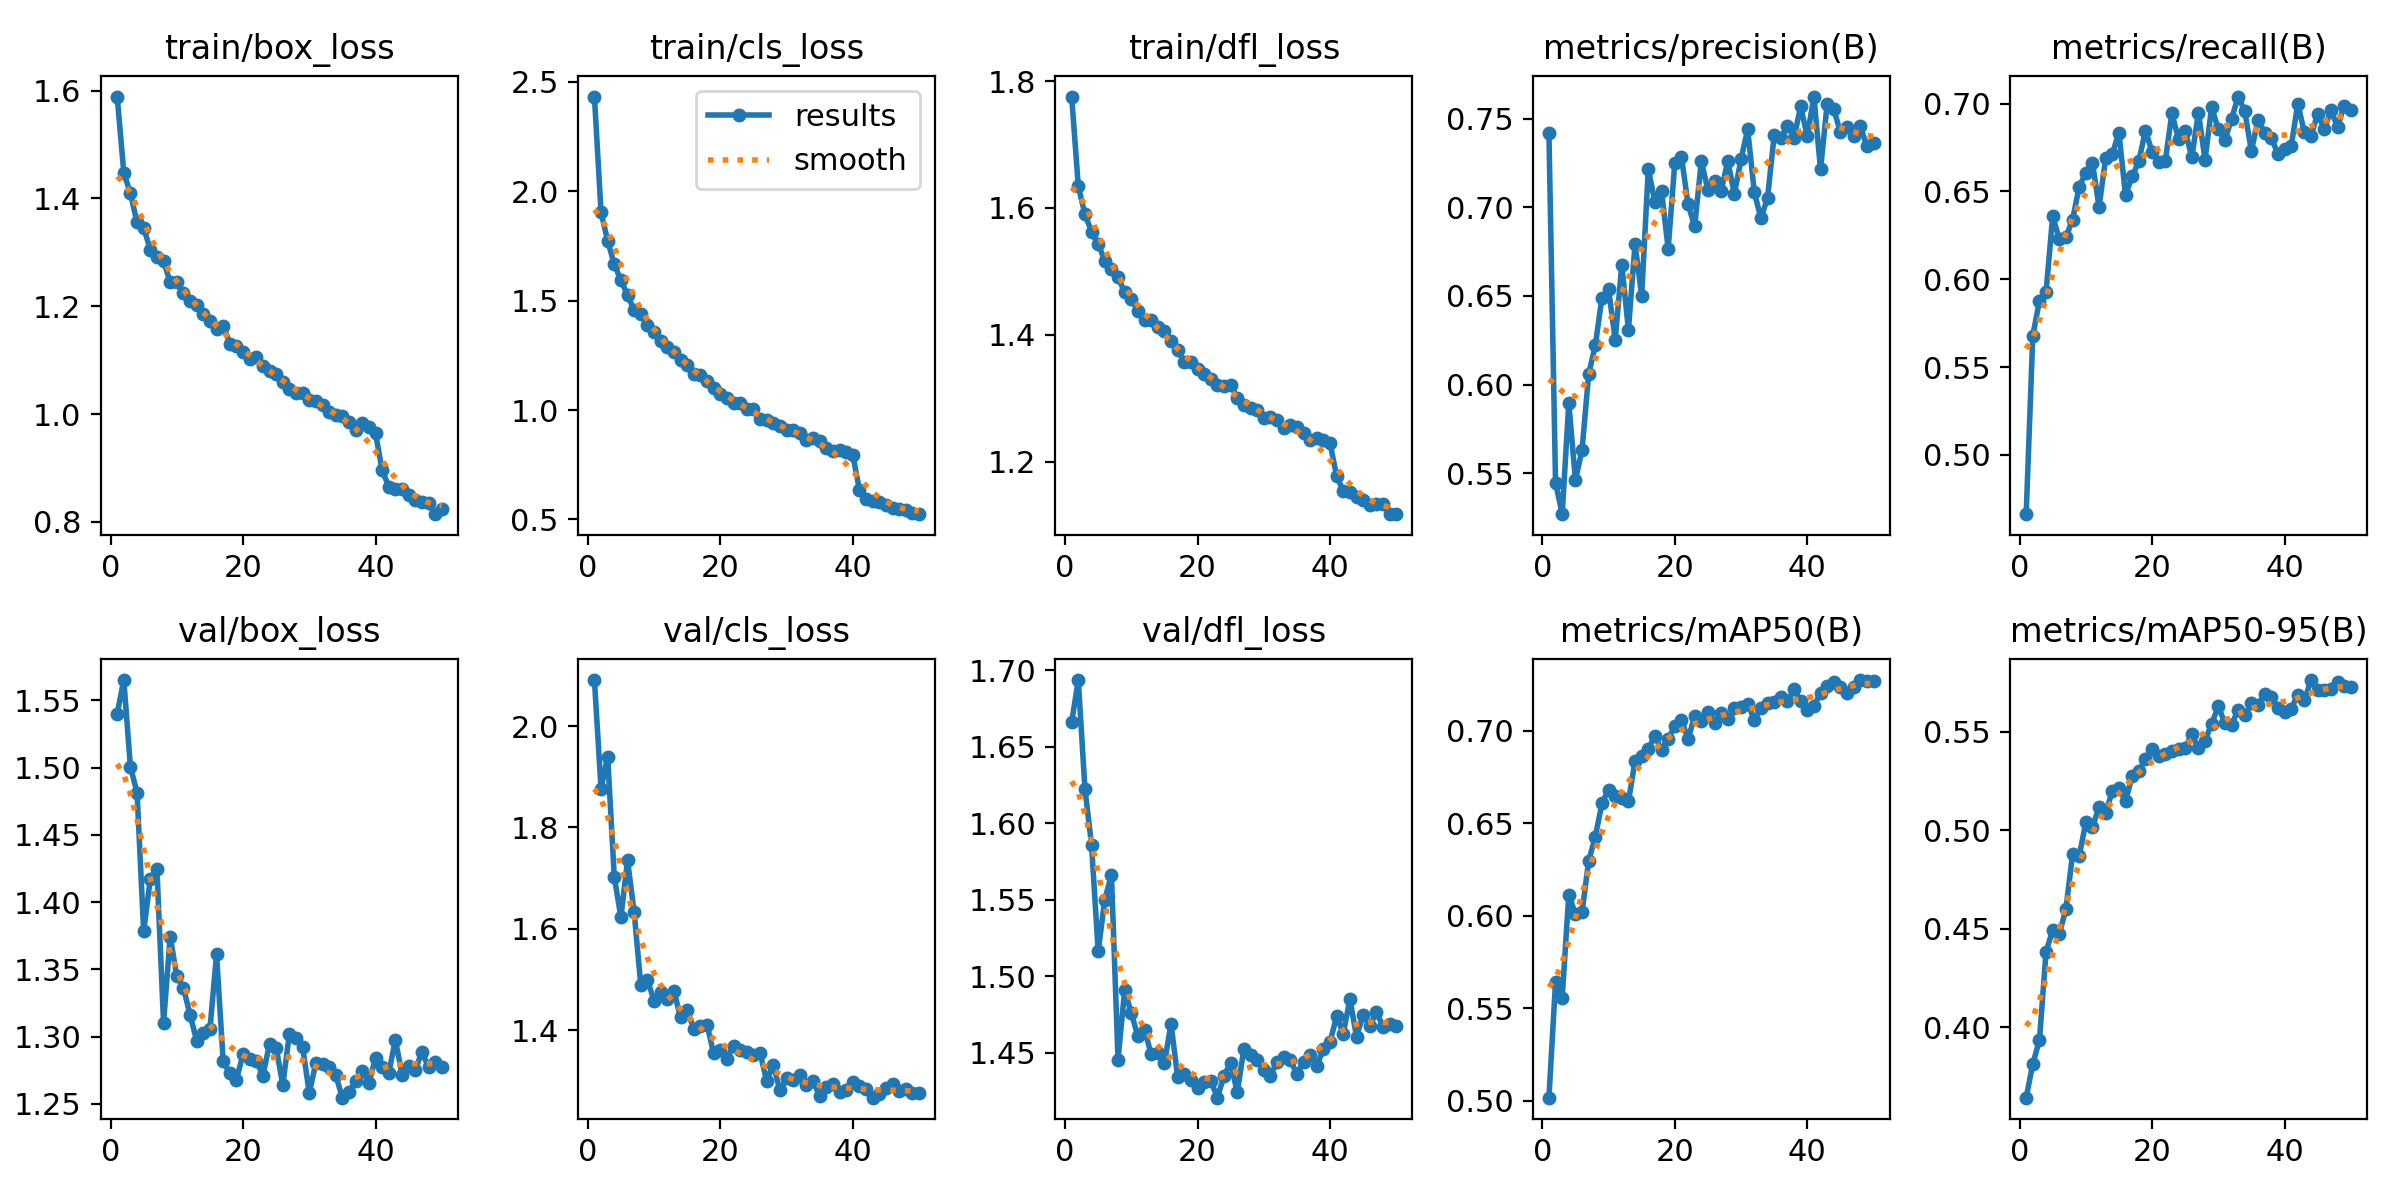

Потери на тренировке уменьшаются, что указывает на успешное обучение. На валидации потери тоже уменьшаются, но после примерно 30 эпохи начинают незначительно увеличиваться, что может означать начало переобучения.

Метрики постоянно растут, но уже на последних эпохах прирост метрик начинает замедляться.

Метрики улучшились по сравнению с предыдущей моделью.

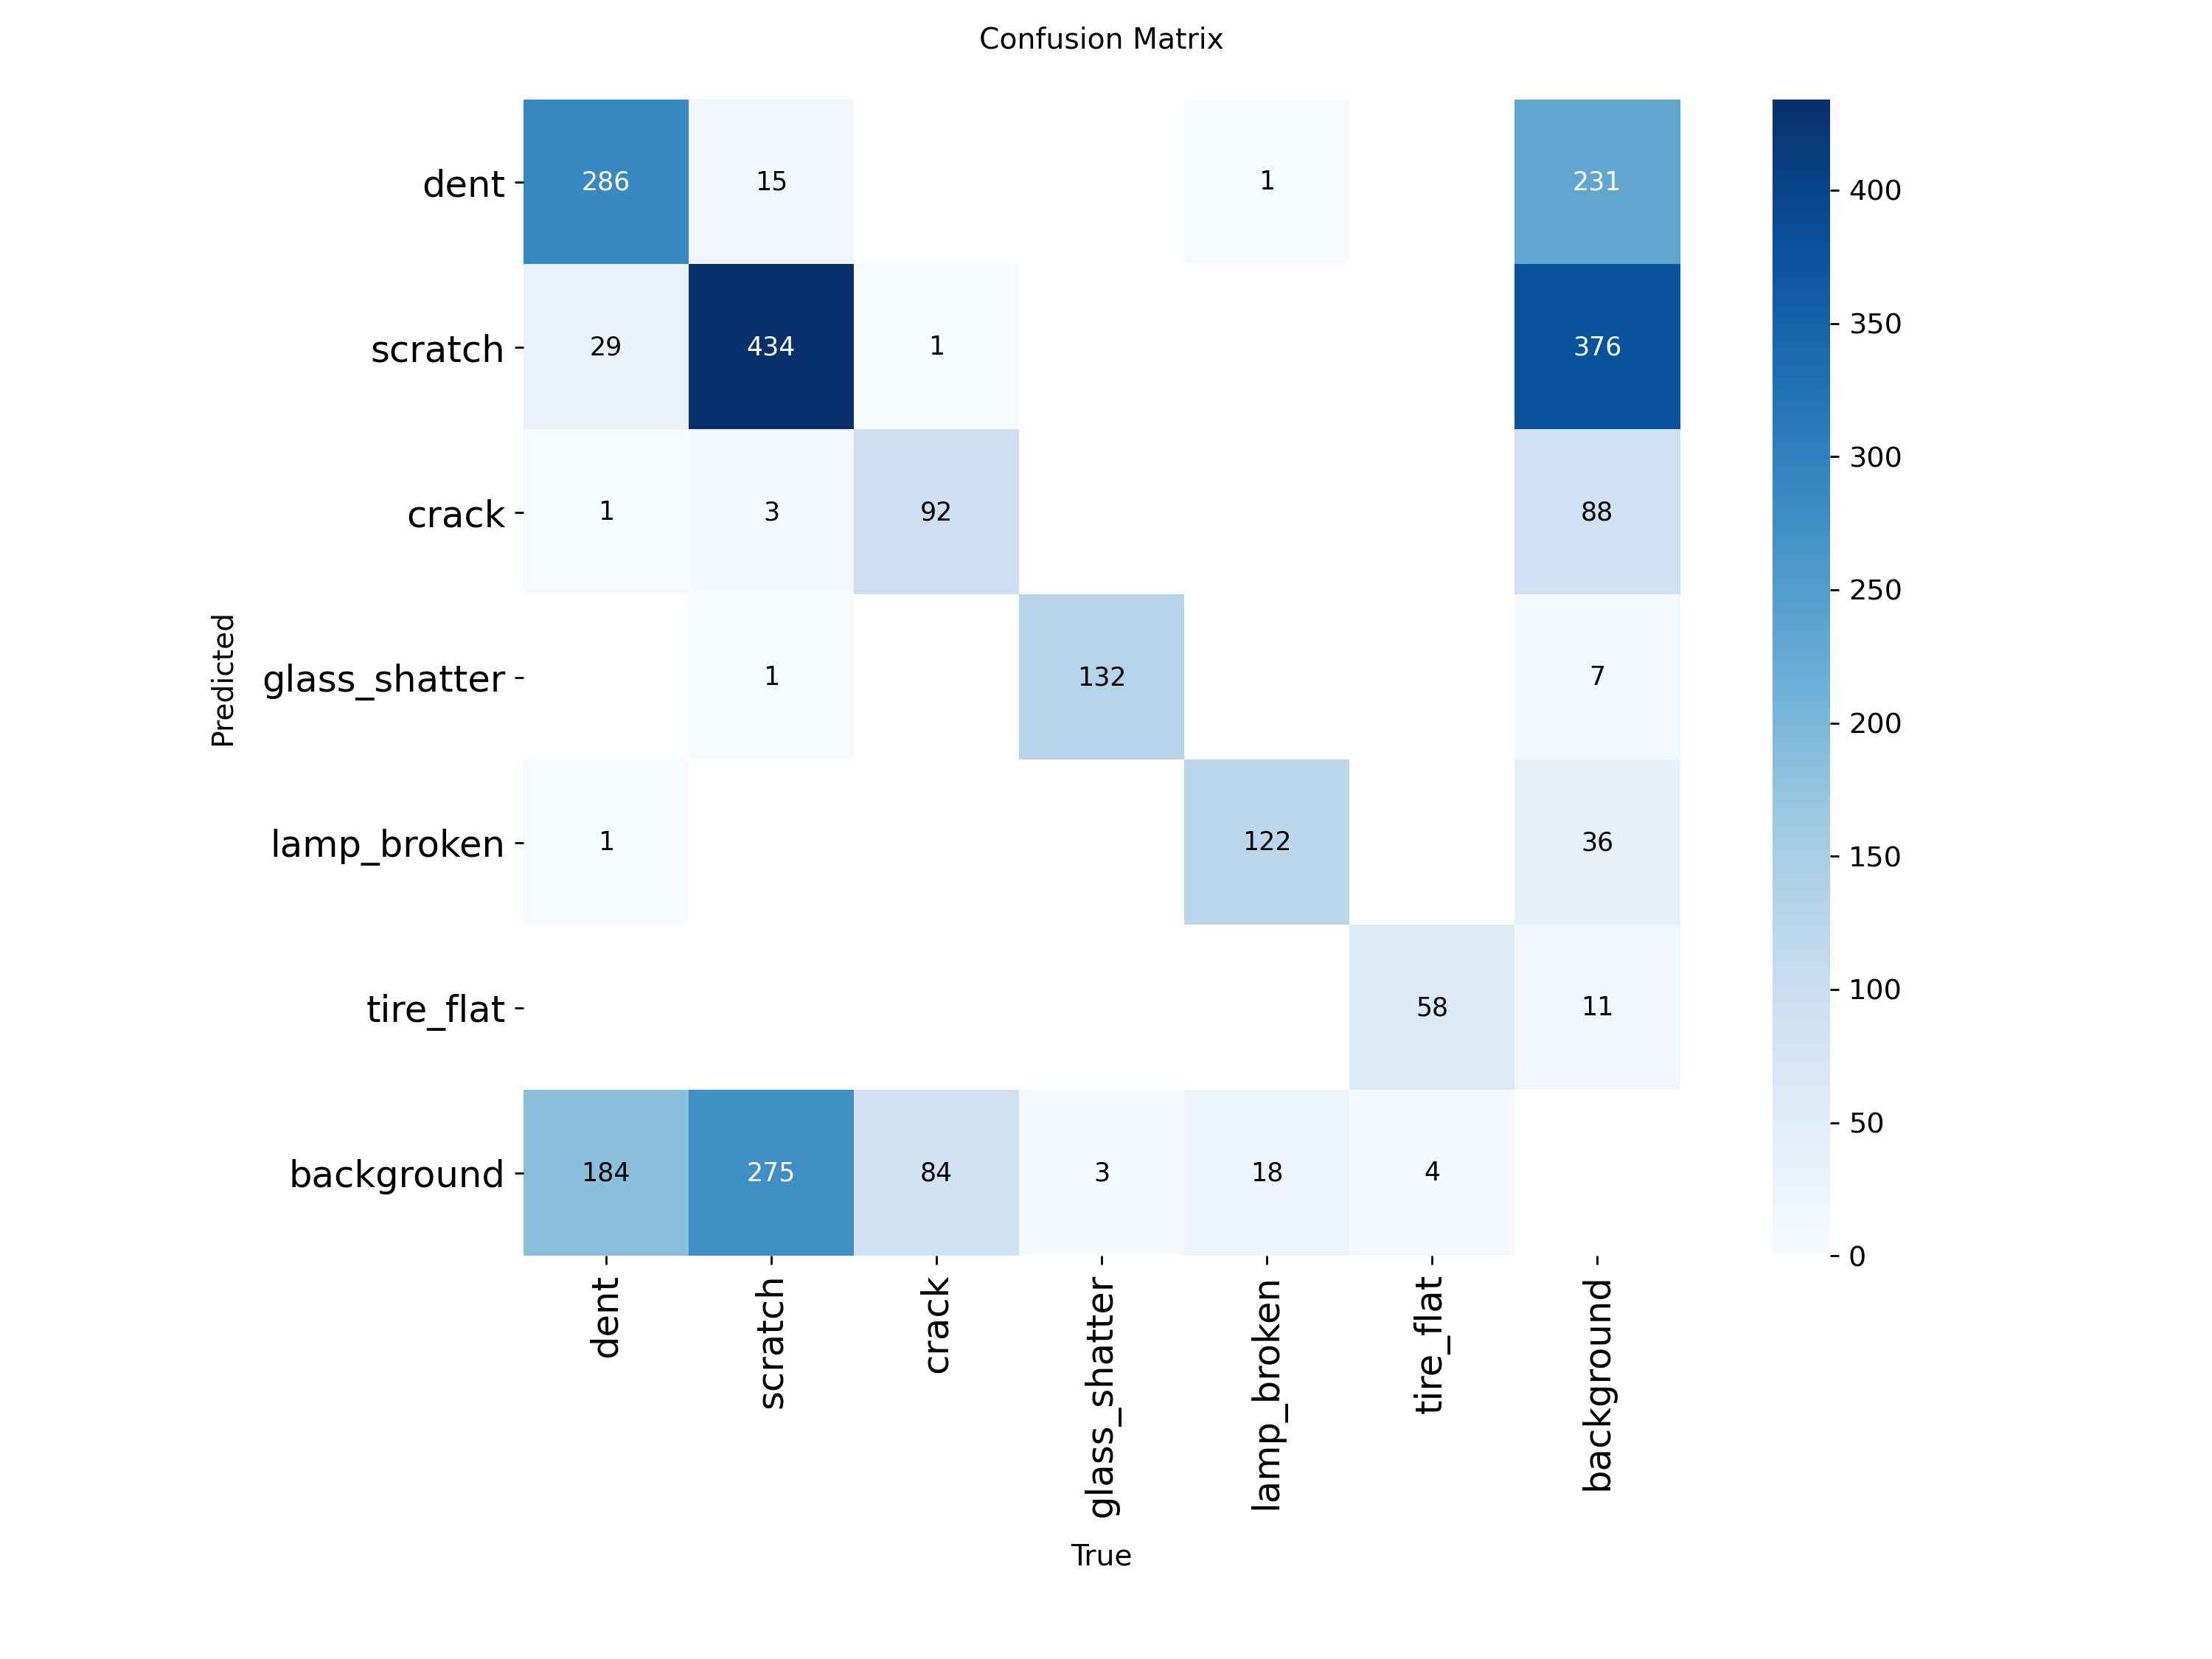

Матрица ошибок показывает, что путаница с фоном для dent и scratch осталась.

Можно попробовать добавить регуляризацию для минимизации переобучения, уменьшить количество эпох до 40, усилить аугментацию и взять более сложную модель YOLO.


## Обучение модели yolo11l

### Обучаем с настройкой гиперпараметров

In [ ]:
large_model = YOLO('yolo11l.pt')

data = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml'

large_model.train(
    data=data,
    epochs=40,
    imgsz=640,
    batch=16,
    optimizer='AdamW',
    lr0=0.0005,
    freeze=2,
    hsv_h=0.05,
    degrees=5,
    translate=0.2,
    scale=0.3,
    mosaic=1,
    mixup=0.2,
    copy_paste=0.3,
    patience=10,
    project='/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results'
)

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=2, half=False, hsv_h=0.05, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective

train: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.2±3.9 ms, read: 64.5±66.5 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      9.79G      1.672       2.56      1.915         65        640: 100%|██████████| 176/176 [03:41<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:31<00:00,  1.23s/it]


                   all        810       1744      0.599      0.263      0.268      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      9.99G      1.668      2.359      1.923         94        640: 100%|██████████| 176/176 [02:22<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]

                   all        810       1744      0.393      0.361      0.378      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40        10G      1.693      2.407      1.953         67        640: 100%|██████████| 176/176 [02:27<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


                   all        810       1744      0.602      0.325      0.345      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40        10G      1.639      2.335      1.911         70        640: 100%|██████████| 176/176 [02:27<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


                   all        810       1744      0.482       0.47      0.451      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40        10G      1.619       2.25      1.897         87        640: 100%|██████████| 176/176 [02:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.467      0.489      0.471      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40        10G      1.541      2.148      1.833         97        640: 100%|██████████| 176/176 [02:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]

                   all        810       1744      0.544      0.518       0.52      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40        10G      1.531      2.105      1.819         90        640: 100%|██████████| 176/176 [02:26<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


                   all        810       1744      0.573      0.554      0.559      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40        10G      1.505      2.022      1.788         76        640: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


                   all        810       1744      0.578      0.538      0.542        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40        10G      1.481      1.996      1.772         78        640: 100%|██████████| 176/176 [02:21<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


                   all        810       1744      0.611      0.561      0.583      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40        10G       1.46      1.903      1.747         94        640: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.34it/s]


                   all        810       1744      0.582      0.561      0.584      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40        10G      1.426      1.858      1.719         87        640: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


                   all        810       1744      0.558      0.558       0.59      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      10.1G       1.41      1.841        1.7        114        640: 100%|██████████| 176/176 [02:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


                   all        810       1744      0.611      0.605      0.614      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      10.1G      1.394      1.797      1.693         75        640: 100%|██████████| 176/176 [02:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]

                   all        810       1744      0.609      0.609      0.629      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      10.1G      1.363      1.757      1.675         73        640: 100%|██████████| 176/176 [02:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


                   all        810       1744      0.674      0.614      0.645      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40        10G      1.363      1.725      1.659         90        640: 100%|██████████| 176/176 [02:18<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]

                   all        810       1744      0.675      0.616      0.654      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40        10G      1.338      1.689      1.644         88        640: 100%|██████████| 176/176 [02:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744       0.67      0.643      0.682       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40        10G      1.335      1.658      1.638         84        640: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

                   all        810       1744      0.712      0.625       0.67       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      10.1G      1.299      1.603      1.617         85        640: 100%|██████████| 176/176 [02:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]

                   all        810       1744      0.666      0.632      0.669      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40        10G      1.296      1.592      1.615         82        640: 100%|██████████| 176/176 [02:18<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]

                   all        810       1744      0.659      0.669      0.679      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40        10G      1.283      1.561      1.598         61        640: 100%|██████████| 176/176 [02:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]

                   all        810       1744      0.731      0.655      0.696      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40        10G       1.27      1.545      1.587        103        640: 100%|██████████| 176/176 [02:23<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.40it/s]

                   all        810       1744       0.74      0.645      0.694      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40        10G      1.252      1.495      1.569         56        640: 100%|██████████| 176/176 [02:17<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.45it/s]

                   all        810       1744      0.726      0.683      0.712      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40        10G      1.255      1.515      1.572         78        640: 100%|██████████| 176/176 [02:20<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.37it/s]

                   all        810       1744      0.706      0.697      0.704      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40        10G      1.232      1.452      1.558        119        640: 100%|██████████| 176/176 [02:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


                   all        810       1744      0.686       0.68      0.695      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40        10G      1.221      1.431      1.548         77        640: 100%|██████████| 176/176 [02:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]

                   all        810       1744      0.677      0.702       0.71      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40        10G      1.199      1.407      1.529         69        640: 100%|██████████| 176/176 [02:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.39it/s]

                   all        810       1744      0.705      0.683      0.719      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40        10G      1.208      1.413      1.529         71        640: 100%|██████████| 176/176 [02:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


                   all        810       1744      0.726      0.683      0.718      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40        10G      1.174      1.357      1.503         78        640: 100%|██████████| 176/176 [02:26<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.35it/s]

                   all        810       1744      0.739       0.67      0.728      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40        10G      1.162      1.341      1.505         79        640: 100%|██████████| 176/176 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.41it/s]

                   all        810       1744       0.72      0.714      0.731      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40        10G      1.155      1.326      1.497         70        640: 100%|██████████| 176/176 [02:19<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]

                   all        810       1744      0.726      0.704      0.729      0.564


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40        10G     0.9938      1.012      1.327         24        640: 100%|██████████| 176/176 [02:13<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]

                   all        810       1744      0.732      0.696      0.746      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      10.1G     0.9768     0.9116      1.317         40        640: 100%|██████████| 176/176 [02:14<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


                   all        810       1744      0.759      0.707      0.742      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40        10G     0.9408     0.8625      1.288         32        640: 100%|██████████| 176/176 [02:15<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]

                   all        810       1744       0.75      0.708      0.747       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40        10G     0.9226     0.8286      1.275         27        640: 100%|██████████| 176/176 [02:14<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]

                   all        810       1744      0.745      0.725       0.76      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40        10G     0.9196     0.7992      1.268         29        640: 100%|██████████| 176/176 [02:14<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


                   all        810       1744      0.772      0.715      0.761      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      9.99G     0.8828       0.75      1.245         45        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


                   all        810       1744      0.754      0.724       0.76      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40        10G     0.8699     0.7353      1.235         34        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

                   all        810       1744      0.773      0.717      0.763      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40        10G      0.862      0.711      1.219         35        640: 100%|██████████| 176/176 [02:14<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


                   all        810       1744      0.778      0.724      0.765      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40        10G     0.8446     0.6802      1.208         36        640: 100%|██████████| 176/176 [02:15<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]

                   all        810       1744      0.763      0.736      0.765      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40        10G     0.8286     0.6656      1.197         33        640: 100%|██████████| 176/176 [02:14<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:17<00:00,  1.47it/s]

                   all        810       1744      0.801      0.712      0.771      0.609



40 epochs completed in 1.837 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/last.pt, 51.2MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.pt, 51.2MB

Validating /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:22<00:00,  1.13it/s]


                   all        810       1744      0.787       0.72      0.772      0.609
                  dent        352        501      0.696      0.534      0.619      0.353
               scratch        431        728      0.646      0.537      0.599       0.35
                 crack        122        177      0.693      0.497      0.546      0.283
         glass_shatter        134        135       0.96      0.985      0.994       0.96
           lamp_broken        139        141      0.827      0.848        0.9      0.787
             tire_flat         59         62      0.899      0.919      0.975      0.921
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79b0704b6dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Экспортируем модель, так как она показала себя лучше всех.

In [ ]:
YOLO('/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.pt').export(format='onnx')

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11l summary (fused): 190 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (48.8 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 5.3s, saved as '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.onnx' (96.8 MB)

Export complete (7.9s)
Results saved to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.onnx imgsz=6

'/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.onnx'

### Обучение с изменением некоторых гиперпараметров

Так как у моделей до этого явные проблемы с трещинами, царапинами и вмятинами, попробуем увеличить размер изображения, чтобы модель лучше распознавала мелкие детали.

In [ ]:
another_l_model = YOLO('yolo11l.pt')

data = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml'

another_l_model.train(
    data=data,
    epochs=40,
    imgsz=1024, # Увеличим размер, чтобы лучше обнаруживать мелкие детали.
    batch=9,
    optimizer='AdamW',
    lr0=0.0005,
    freeze=2,
    hsv_h=0.05,
    degrees=5,
    translate=0.2,
    scale=0.1,
    mosaic=0.5, # Будет применяться к 50% изображений.
    mixup=0.2,
    copy_paste=0.3,
    patience=10,
    perspective=0.0005, # Применяет к изображению случайное преобразование перспективы, улучшая способность модели понимать объекты в трехмерном пространстве.
    shear=2, # Обрезает изображение на определенный градус, имитируя эффект просмотра объектов под разными углами.
    erasing=0.2,
    project='/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results'
)

Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=9, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=2, half=False, hsv_h=0.05, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspecti

train: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 3.5±3.7 ms, read: 167.9±24.0 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0004921875), 173 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      13.2G      1.942      3.121      2.442         32       1024: 100%|██████████| 313/313 [21:04<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [01:02<00:00,  1.39s/it]


                   all        810       1744       0.65      0.195      0.211     0.0857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      13.4G      1.966      2.975      2.487         20       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


                   all        810       1744      0.509       0.33      0.316      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      13.3G      1.939      2.963      2.456         40       1024: 100%|██████████| 313/313 [05:06<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.59it/s]


                   all        810       1744      0.593      0.359      0.355      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      13.3G      1.861      2.856       2.38         29       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.61it/s]


                   all        810       1744      0.408      0.421      0.393      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      13.3G      1.816      2.727      2.319         19       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.61it/s]

                   all        810       1744      0.399       0.44      0.422      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      13.3G      1.792      2.646      2.311         38       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.59it/s]

                   all        810       1744      0.434      0.473      0.443      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      13.3G      1.747      2.554      2.267         35       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.60it/s]

                   all        810       1744      0.552      0.493      0.498      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      13.4G      1.721      2.487      2.247         27       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]


                   all        810       1744      0.546      0.496      0.508        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      13.3G      1.683      2.431      2.207         37       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.549      0.516      0.525      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      13.3G      1.652      2.332      2.166         40       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.68it/s]


                   all        810       1744      0.559      0.511      0.535       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      13.3G      1.637      2.303      2.136         29       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.60it/s]

                   all        810       1744      0.616      0.537      0.566      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      13.3G      1.607      2.243      2.136         28       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.568      0.559      0.569      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      13.3G      1.604      2.213      2.121         23       1024: 100%|██████████| 313/313 [05:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]


                   all        810       1744      0.601      0.564      0.587      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      13.3G       1.57      2.129      2.089         41       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.61it/s]

                   all        810       1744      0.639      0.571      0.591       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      13.3G      1.562      2.139      2.086         49       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.65it/s]

                   all        810       1744      0.599      0.559       0.59      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      13.3G      1.553      2.082      2.063         28       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]

                   all        810       1744      0.585      0.582      0.605      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      13.3G      1.534      2.057      2.056         55       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.63it/s]

                   all        810       1744      0.637      0.585       0.62       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      13.3G      1.511      2.023      2.031         32       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.65it/s]

                   all        810       1744      0.636      0.612      0.628      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      13.3G      1.494       1.95      2.016         35       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]

                   all        810       1744      0.665      0.606      0.633      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      13.3G      1.482      1.927      1.999         27       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.65it/s]

                   all        810       1744       0.65      0.613      0.639      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      13.3G      1.457      1.881       1.97         21       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.66it/s]

                   all        810       1744      0.661      0.621      0.647      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      13.3G      1.472      1.904      1.989         22       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.66it/s]

                   all        810       1744       0.67      0.617      0.645      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      13.4G      1.457      1.861       1.98         34       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.66it/s]

                   all        810       1744       0.68      0.642      0.665      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      13.3G      1.439       1.81      1.955         27       1024: 100%|██████████| 313/313 [05:02<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744        0.7      0.631      0.665      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      13.3G      1.418      1.777      1.941         48       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.68it/s]

                   all        810       1744       0.71      0.634      0.669       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      13.3G       1.42      1.763      1.941         42       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.691      0.642      0.672      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      13.3G      1.391      1.731       1.91         22       1024: 100%|██████████| 313/313 [05:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.65it/s]

                   all        810       1744      0.692      0.667      0.685      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      13.3G      1.377      1.683      1.889         28       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]

                   all        810       1744      0.707      0.657      0.694      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      13.3G      1.358      1.647      1.882         20       1024: 100%|██████████| 313/313 [05:04<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.63it/s]

                   all        810       1744      0.715      0.649      0.691      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      13.3G      1.372      1.647      1.882         19       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]

                   all        810       1744      0.688       0.67      0.703        0.5


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      13.3G      1.207      1.271      1.733         16       1024:  65%|██████▌   | 204/313 [03:20<01:41,  1.08it/s]

Так как Google Colab у меня без подписки, придётся возобновлять обучение.

In [ ]:
continue_train = YOLO("/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/last.pt")
results = continue_train.train(resume=True)

Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=9, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=2, half=False, hsv_h=0.05, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/last.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train4, nbs=64, nms=False, opset=

100%|██████████| 755k/755k [00:00<00:00, 25.9MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

100%|██████████| 5.35M/5.35M [00:00<00:00, 87.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 1.8±0.7 MB/s, size: 771.1 KB)


train: Scanning /content/drive/.shortcut-targets-by-id/1TwqsJ20oW8_Iho7gSBbp326I3o-g57jy/CAR_DAMAGE/yolo_dataset/labels/train2017... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [18:11<00:00,  2.58it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1TwqsJ20oW8_Iho7gSBbp326I3o-g57jy/CAR_DAMAGE/yolo_dataset/labels/train2017.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.4 ms, read: 1.2±0.5 MB/s, size: 618.6 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1TwqsJ20oW8_Iho7gSBbp326I3o-g57jy/CAR_DAMAGE/yolo_dataset/labels/val2017... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [05:01<00:00,  2.68it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1TwqsJ20oW8_Iho7gSBbp326I3o-g57jy/CAR_DAMAGE/yolo_dataset/labels/val2017.cache
Plotting labels to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0004921875), 173 bias(decay=0.0)
Resuming training /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/last.pt from epoch 31 to 40 total epochs
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4
Starting training for 40 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   

      31/40      13.3G      1.216      1.269      1.752         16       1024: 100%|██████████| 313/313 [04:56<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]

                   all        810       1744      0.698      0.664      0.694      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      13.3G      1.199      1.185      1.733         17       1024: 100%|██████████| 313/313 [04:58<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.61it/s]

                   all        810       1744      0.739      0.661      0.707      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      13.3G      1.162      1.136      1.695         23       1024: 100%|██████████| 313/313 [05:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.739       0.67      0.715      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      13.3G      1.151       1.11      1.681         11       1024: 100%|██████████| 313/313 [05:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.716      0.683      0.718      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      13.3G      1.125      1.068      1.659         26       1024: 100%|██████████| 313/313 [05:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.65it/s]

                   all        810       1744      0.748      0.663      0.718      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      13.3G      1.114      1.026      1.645         20       1024: 100%|██████████| 313/313 [04:57<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.63it/s]

                   all        810       1744      0.734      0.686      0.723      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      13.3G      1.087          1      1.623         17       1024: 100%|██████████| 313/313 [05:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.772      0.677      0.732      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      13.3G      1.071      0.968       1.61         14       1024: 100%|██████████| 313/313 [04:59<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.753      0.666      0.726      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      13.3G      1.065     0.9394      1.601         29       1024: 100%|██████████| 313/313 [04:59<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744       0.75      0.683      0.732      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      13.3G      1.061     0.9162      1.595         11       1024: 100%|██████████| 313/313 [04:58<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]

                   all        810       1744      0.766      0.683      0.734      0.535



10 epochs completed in 0.918 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/last.pt, 51.2MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/best.pt, 51.2MB

Validating /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30<00:00,  1.50it/s]


                   all        810       1744       0.75      0.684      0.731      0.539
                  dent        352        501      0.643      0.511       0.57      0.318
               scratch        431        728      0.645      0.514      0.569       0.32
                 crack        122        177      0.479       0.39      0.408      0.193
         glass_shatter        134        135      0.992      0.975      0.991      0.871
           lamp_broken        139        141      0.776      0.862      0.889      0.708
             tire_flat         59         62      0.964      0.854      0.961      0.826
Speed: 0.6ms preprocess, 24.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4


In [ ]:
continued_model = YOLO('/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/best.pt')

data = '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml'

continued_model.train(
    data=data,
    epochs=20,
    imgsz=1024,
    batch=9,
    optimizer='AdamW',
    lr0=0.0001,
    freeze=1,
    hsv_h=0.05,
    degrees=5,
    translate=0.2,
    scale=0.1,
    mosaic=0,
    mixup=0,
    copy_paste=0.3,
    patience=10,
    perspective=0.0005,
    shear=2,
    erasing=0.2,
    project='/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results',
    name='train_continued_non_mosaic'
)

Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=9, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.2, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=1, half=False, hsv_h=0.05, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0, mode=train, model=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train4/weights/best.pt, momentum=0.937, mosaic=0, multi_scale=False, name=train_continued_non_mosaic, nbs=64, n

100%|██████████| 755k/755k [00:00<00:00, 43.6MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

  8                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  2   1455616  ultralytics.nn.modules.block.C2PSA           [512, 512, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   2496512  ultralytics.nn.modules.block.C3k2            [1024, 512, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  2    756736  ultralytics.nn.modules.block.C3k2            [1024

100%|██████████| 5.35M/5.35M [00:00<00:00, 144MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 6.4±13.1 ms, read: 1.6±0.2 MB/s, size: 771.1 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [26:26<00:00,  1.78it/s]


train: New cache created: /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/train2017.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.1±0.7 ms, read: 1.0±0.3 MB/s, size: 618.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [07:40<00:00,  1.76it/s]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/val2017.cache
Plotting labels to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued_non_mosaic/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0004921875), 173 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued_non_mosaic
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      13.8G      1.224      1.282      1.754         18       1024: 100%|██████████| 313/313 [05:27<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33<00:00,  1.34it/s]

                   all        810       1744      0.714      0.643      0.685       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      13.9G      1.152      1.108      1.675         16       1024: 100%|██████████| 313/313 [05:15<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32<00:00,  1.37it/s]

                   all        810       1744      0.703      0.685      0.709      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      13.8G      1.137      1.068      1.665         15       1024: 100%|██████████| 313/313 [05:17<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.58it/s]

                   all        810       1744      0.722      0.685      0.719      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      13.9G      1.097       1.01      1.628         19       1024: 100%|██████████| 313/313 [05:14<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31<00:00,  1.43it/s]

                   all        810       1744      0.721      0.695       0.71      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      13.9G      1.092     0.9887      1.622         14       1024: 100%|██████████| 313/313 [05:15<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.60it/s]

                   all        810       1744      0.725      0.694      0.719      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      13.9G      1.077     0.9603      1.597         15       1024: 100%|██████████| 313/313 [05:11<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.57it/s]

                   all        810       1744      0.748      0.689      0.717      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      13.9G      1.064      0.931       1.59         10       1024: 100%|██████████| 313/313 [05:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.57it/s]

                   all        810       1744      0.739      0.701      0.721      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      13.9G      1.067     0.9181       1.59         14       1024: 100%|██████████| 313/313 [05:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31<00:00,  1.45it/s]

                   all        810       1744      0.752      0.685      0.731      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      13.9G      1.051     0.8976      1.575         18       1024: 100%|██████████| 313/313 [05:15<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30<00:00,  1.45it/s]

                   all        810       1744      0.736      0.693      0.725      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      13.9G      1.035     0.8752      1.563         16       1024: 100%|██████████| 313/313 [05:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.60it/s]

                   all        810       1744       0.73      0.691      0.723      0.531


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      13.8G      1.027     0.8656      1.561         13       1024: 100%|██████████| 313/313 [05:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28<00:00,  1.59it/s]

                   all        810       1744      0.749      0.706      0.738      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      13.9G      1.017     0.8324      1.545         10       1024:  44%|████▍     | 139/313 [02:22<02:51,  1.02it/s]

In [4]:
YOLO('/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.pt').export(format='onnx')

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11l summary (fused): 190 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 10, 21504) (48.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 15.8s, saved as '/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.onnx' (97.0 MB)

Export complete (29.2s)
Results saved to /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.onnx imgsz=1024  
Validate:        yolo val task=detect model=/content/drive/MyDrive/Colab Noteb

'/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.onnx'

In [7]:
test_model1 = YOLO('/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.onnx', task='detect')
results1 = test_model1.val(data='/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml', split='test', imgsz=1024)
print(results1.box.map)

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/another_l_results/train_continued2/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider
Setting batch=1 input of shape (1, 3, 1024, 1024)
val: Fast image access ✅ (ping: 0.8±0.5 ms, read: 161.5±65.2 MB/s, size: 832.2 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/test2017.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 374/374 [33:34<00:00,  5.39s/it]


                   all        374        785      0.797      0.677      0.737      0.531
                  dent        157        236      0.719      0.553       0.63      0.344
               scratch        183        307      0.685       0.57      0.627      0.336
                 crack         48         70      0.585      0.357      0.434      0.216
         glass_shatter         71         71      0.898      0.958      0.967      0.823
           lamp_broken         65         69      0.912      0.783      0.848      0.664
             tire_flat         31         32      0.981      0.844      0.914      0.803
Speed: 4.8ms preprocess, 5343.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val2
0.5308571447025281


In [9]:
test_model2 = YOLO('/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.onnx', task='detect')
results2 = test_model2.val(data='/content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/data.yaml', split='test')
print(results2.box.map)

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/large_results/train3/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 9.6±19.9 ms, read: 97.1±64.1 MB/s, size: 788.2 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/CAR_DAMAGE/yolo_dataset/labels/test2017.cache... 374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 374/374 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 374/374 [12:31<00:00,  2.01s/it]


                   all        374        785      0.787      0.706      0.763      0.589
                  dent        157        236      0.722       0.55      0.625      0.369
               scratch        183        307       0.66      0.549      0.639      0.355
                 crack         48         70      0.683      0.432      0.484      0.247
         glass_shatter         71         71      0.874      0.986      0.989      0.927
           lamp_broken         65         69      0.921      0.812      0.915      0.748
             tire_flat         31         32      0.864      0.906      0.925      0.888
Speed: 1.8ms preprocess, 1974.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val3
0.5889350326537326
